In [258]:
import learn_kuramoto_files as lk
import numpy as np
import importlib as imp
import pandas as pd
import time
from scipy import signal
imp.reload(lk)

<module 'learn_kuramoto_files' from 'C:\\Users\\mpanaggio\\Box\\MRC\\learn_model_fourier\\learn_network_structure\\learn_kuramoto_files.py'>

In [438]:
## define model parameters
num_osc=20
mu_freq=0.15  # mean natural frequency
sigma_freq=0  # std natural frequency
p_val=1
p_community=np.matrix([[1,p_val],[p_val,1]])  # probability of connection for erdos renyi
K_community=0.5*np.matrix([[1,0.8],[0.8,1]])  # probability of connection for erdos renyi
random_seed=-1 # -1 to ignore
alpha=np.pi/2-0.01
coupling_function=lambda x: np.sin(x-alpha)  # Gamma from kuramoto model
#coupling_function=lambda x: np.sin(x-0.2)+0.1*np.cos(2*x) # Gamma from kuramoto model

##############################################################################
## define numerical solution parameters
dt=0.1     # time step for numerical solution
tmax=5000.0    # maximum time for numerical solution
noise_level=0.0 # post solution noise added
num_repeats=1 # number of restarts for numerical solution
## Note: the  loop parameter value will overwrite the value above

In [439]:
def generate_community_network(num_osc,pmat,Kmat=1):
    Kmat=np.matrix(Kmat)
    num_communities=pmat.shape[0]
    oscillators_per_community=np.ceil(num_osc/num_communities)
    community_dict=dict(zip(range(num_osc),[int(k//oscillators_per_community)  for k in range(num_osc)])) 
    A=np.zeros((num_osc,num_osc))
    for k in range(num_osc):
        for j in range(k):
            pval=pmat[community_dict[k],community_dict[j]]
            if np.random.rand()<pval:
                if Kmat.shape[0]>1:
                    A[k,j]=Kmat[community_dict[k],community_dict[j]]
                    A[j,k]=Kmat[community_dict[k],community_dict[j]]
                else:
                    A[k,j]=1
                    A[j,k]=1
    return A,community_dict
#pmat=np.matrix([[1,0.5],[0.5,1]])
# pmat=np.matrix([[1,0.5,0.1],[0.5,1, 0.3],[0.1,0.3,1]])
# A=generate_clustered_network(500,pmat)
# plt.imshow(A)

{'dt': 0.1, 'tmax': 5000.0, 'noise': 0.0, 'ts_skip': 1, 'num_repeats': 1}
(20, 1)
(20, 20)
1.0
<function <lambda> at 0x000000002677F598>


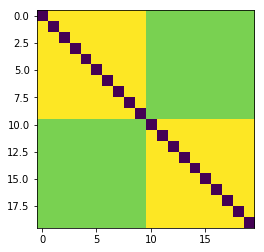

In [440]:
A,community_dict=generate_community_network(num_osc,p_community,K_community)
system_params={'w': lk.random_natural_frequencies(num_osc,mu=mu_freq,sigma=sigma_freq,seed=random_seed),
        'A': A,
        'K': 1.0,
        'Gamma': coupling_function
        }
solution_params={'dt':dt,
                 'tmax':tmax,
                 'noise': noise_level,
                 'ts_skip': 1, # don't skip timesteps
                 'num_repeats': num_repeats
                 }
print(solution_params)
print(system_params['w'].shape)
print(system_params['A'].shape)
print(system_params['K'])
print(system_params['Gamma'])
plt.imshow(A)

In [441]:
## generate training data
#tv=np.linspace(0.0,tmax,int(tmax/dt+1))
tmp=[x for x in community_dict.values() if x==0]
IC=np.concatenate([np.zeros((len(tmp))),2*np.pi*np.random.rand(num_osc-len(tmp))])
print(IC.shape)
tv,phases=lk.solve_kuramoto_ode(dt,system_params,tmax,IC)
#old_phases,new_phases=lk.generate_data(system_params,
#                                       solution_params,)

(20,)


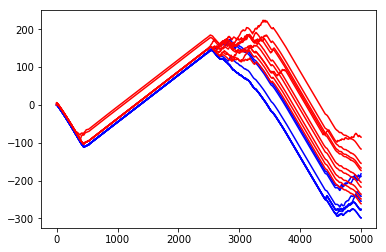

In [442]:
import matplotlib.pyplot as plt
for osc in range(num_osc):
    plt.plot(tv,phases[:,osc],color_dict[community_dict[osc]])
plt.show()

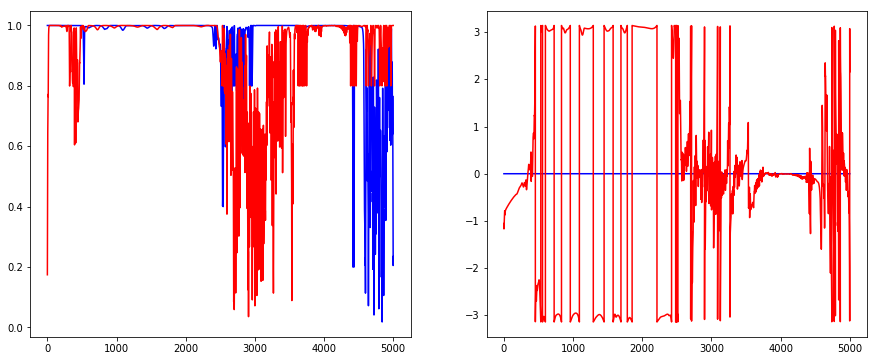

In [443]:
def get_community_op(phases,community_dict,axis=0):
    if axis==1:
        phases=phases.T
    R=np.zeros((phases.shape[0],len(set(community_dict.values()))))
    Psi=np.zeros((phases.shape[0],len(set(community_dict.values()))))
    for k in set(community_dict.values()):
        osc_list=[key for key,val in community_dict.items() if val ==k]
        Z=np.mean(np.exp(1j*phases[:,osc_list]),axis=1)
        R[:,k]=np.abs(Z)
        Psi[:,k]=np.angle(Z)
    if axis==1:
        R=R.T
        Psi=Psi.T
    return R,Psi
R,Psi=get_community_op(phases,community_dict,axis=0)   

num_communities=2
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
for com in range(num_communities):
    plt.plot(tv,R[:,com],color_dict[com])
    #plt.xlim(0,1000)
plt.subplot(1,2,2)
for com in range(num_communities):
    plt.plot(tv,np.angle(np.exp(1j*(Psi[:,com]-Psi[:,0]))),color_dict[com])
    #plt.xlim(0,1000)

plt.show()

In [444]:
print(A)

[[0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
  0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.  0.5 0.5 0.5 0.5